In [9]:
import cv2
import glob
from IPython.display import HTML
import math
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np
import pickle
import scipy.ndimage.measurements
import skimage.feature
import time

# Visualization helpers

In [2]:
def color_spectrum(num):
    colors = np.vstack((
        np.linspace(0, 255, num + 1)[:-1],
        np.ones(num) * 255,
        np.ones(num) * 255
    )).astype(np.uint8).T # `num` by 3 HSV colors
    colors = np.array([colors]) # 1 height by `num` width by 3 colors
    colors = cv2.cvtColor(colors, cv2.COLOR_HSV2RGB)
    colors = colors[0] # `num` by 3 colors
    return colors.astype(np.float) # cv2 color input needs to be float

# Define strips in which to search for windows

In [2]:
def get_strip_configs():
    """
    Each tuple contains (
        vertical center of strip,
        vertical height of strip
    )"""
    return [
        (440, 90),
        (470, 180),
        (500, 270)
    ]

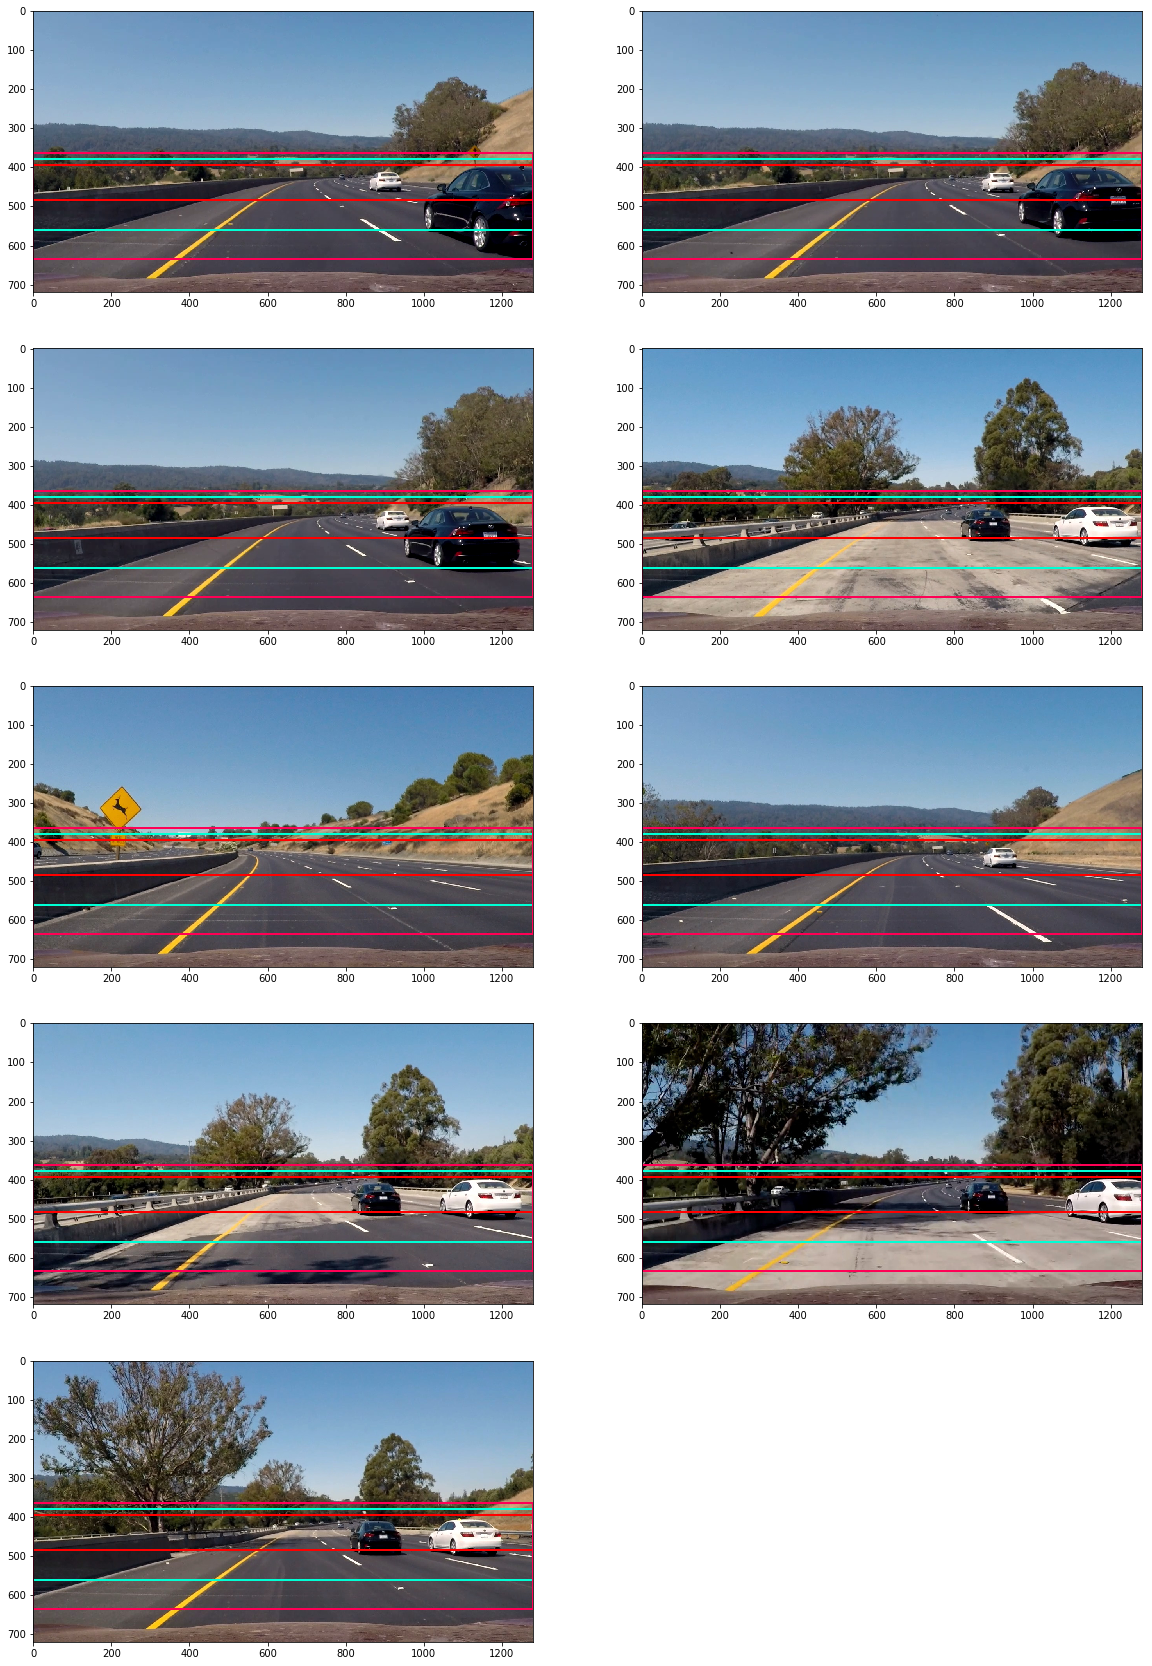

In [4]:
def visualize_strip_configs_test_images():
    def do_visualize(img):
        strip_configs = get_strip_configs()

        colors = color_spectrum(len(strip_configs))

        for (strip_y_center, strip_h), color in zip(strip_configs, colors):
            strip_y_top = int(strip_y_center - strip_h / 2)
            strip_y_btm = int(strip_y_center + strip_h / 2)
            cv2.rectangle(img, (0, strip_y_top), (img.shape[1] - 1, strip_y_btm), color, 3)
    
    img_paths = glob.glob('test_images/*')
    fig, axes = plt.subplots(ncols=2, nrows=math.ceil(len(img_paths) / 2), figsize=(20, 30))
    axes = axes.flatten()
    for ax in axes[len(img_paths):]:
        ax.remove()
    
    for img_path, ax in zip(img_paths, axes):
        img_bgr = cv2.imread(img_path)
        img_rgb = np.array(img_bgr[:,:,::-1])
        do_visualize(img_rgb)
        ax.imshow(img_rgb)

visualize_strip_configs_test_images()

# Run prediction

### Choose trained model

In [3]:
with open('working_dir/overall_training_result.p', 'rb') as f:
    TRAINING_RESULT = pickle.load(f)

# X_SCALER, CLF = TRAINING_RESULT['CLR_RS_SHRUNK16_RESULTS']
# X_SCALER, CLF = TRAINING_RESULT['HOG_LS_CLR_RS_SHRUNK16_RESULTS']
X_SCALER, CLF = TRAINING_RESULT['HOG_LS_CLR_RLS_RESULTS']
print(X_SCALER, CLF)

StandardScaler(copy=True, with_mean=True, with_std=True) LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


In [16]:
# with open('working_dir/hog_training_result.p', 'rb') as f:
#     HOG_TRAINING_RESULT = pickle.load(f)

# X_SCALER, CLF = HOG_TRAINING_RESULT['HLS_RESULTS']
# print(X_SCALER, CLF)

StandardScaler(copy=True, with_mean=True, with_std=True) LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


### Adjust feature extraction based on which classifier model was chosen above

The final choice of feature is:
- For hog feature, use L and S channels from HLS
- For color features, use R channel, and L and S channels from HLS

In [4]:
# Code in this box is reconstructed from the training notebook.

pixels_per_cell = 8
cells_per_block = 2
orientations = 9

cells_per_window = 8
blocks_per_window = cells_per_window - cells_per_block + 1
pixels_per_window = cells_per_window * pixels_per_cell

cells_per_step = 2
pixels_per_step = pixels_per_cell * cells_per_step

def get_window_features_in_strip(strip_rgb, verbose=False):
    def get_hog():
        def hog_helper(img_single_ch):
            return skimage.feature.hog(
                img_single_ch,
                orientations=orientations,
                pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                cells_per_block=(cells_per_block, cells_per_block),
                transform_sqrt=True,
                visualise=False,
                feature_vector=False,
                block_norm='L2-Hys')
        
        if (strip_rgb.shape[0] != pixels_per_window or
            strip_rgb.shape[1] % pixels_per_step != 0):
            
            w = round((strip_rgb.shape[1] / strip_rgb.shape[0] * pixels_per_window) / pixels_per_step) * pixels_per_step
            strip_rgb_resized = cv2.resize(strip_rgb, (w, pixels_per_window))
        else:
            strip_rgb_resized = strip_rgb
        
        if verbose:
            print('for hog, strip is resized to', strip_rgb_resized.shape)
        
#         strip_hsv_resized = cv2.cvtColor(strip_rgb_resized, cv2.COLOR_RGB2HSV)
#         strip_sch = strip_hsv_resized[:,:,1]
#         strip_vch = strip_hsv_resized[:,:,2]
#         hog_sch = hog_helper(strip_sch)
#         hog_vch = hog_helper(strip_vch)
#         whole_hog = np.stack((hog_sch, hog_vch), axis=-1)

        strip_hls_resized = cv2.cvtColor(strip_rgb_resized, cv2.COLOR_RGB2HLS)
        strip_lch = strip_hls_resized[:,:,1]
        strip_sch = strip_hls_resized[:,:,2]
        hog_lch = hog_helper(strip_lch)
        hog_sch = hog_helper(strip_sch)
        whole_hog = np.stack((hog_lch, hog_sch), axis=-1)
        
        if verbose:
            print('num hog block in x dir', whole_hog.shape[1])
        
        window_hogs = []
        for block_ind_x in np.arange(0, whole_hog.shape[1] - blocks_per_window + 2, cells_per_step):
            window_hog = whole_hog[:, block_ind_x : block_ind_x + blocks_per_window].flatten()
            window_hogs.append(window_hog)
            
            if verbose:
                print('hog window block boundary inds', block_ind_x, block_ind_x + blocks_per_window,
                     ' ; feature shape', window_hog.shape)
                assert window_hog.shape == (7 * 7 * 2 * 2 * 9 * 2,)
        return window_hogs
    
    def get_clr(num_windows_x):
        h = 16
        pixels_per_step = int(h / cells_per_window * cells_per_step)
        w = pixels_per_step * (num_windows_x - 1) + h
        if strip_rgb.shape == (h, w):
            strip_rgb_resized = strip_rgb
        else:
            strip_rgb_resized = cv2.resize(strip_rgb, (w, h))
        
        resize_ratio = w / strip_rgb.shape[1]
        
        if verbose:
            print('for color, strip is resized to', strip_rgb_resized.shape)
        
#         strip_hsv_resized = cv2.cvtColor(strip_rgb_resized, cv2.COLOR_RGB2HSV)
#         strip_rch = strip_rgb_resized[:,:,0]
#         strip_sch = strip_hsv_resized[:,:,1]

        strip_hls_resized = cv2.cvtColor(strip_rgb_resized, cv2.COLOR_RGB2HLS)
        strip_rch = strip_rgb_resized[:,:,0]
        strip_lch = strip_hls_resized[:,:,1]
        strip_sch = strip_hls_resized[:,:,2]
        
        window_color_features = []
        for window_ind in range(num_windows_x):
            x0 = pixels_per_step * window_ind
            x1 = x0 + h
            
#             window_rch = strip_rch[:, x0:x1]
#             window_sch = strip_sch[:, x0:x1]
#             rch_spatial = window_rch.flatten()
#             sch_spatial = window_sch.flatten()
#             rch_hist = np.histogram(window_rch, bins=32, range=(0, 256))
#             sch_hist = np.histogram(window_sch, bins=32, range=(0, 256))
#             features = np.concatenate((rch_spatial, sch_spatial, rch_hist[0], sch_hist[0]))

            window_rch = strip_rch[:, x0:x1]
            window_lch = strip_lch[:, x0:x1]
            window_sch = strip_sch[:, x0:x1]
            rch_spatial = window_rch.flatten()
            lch_spatial = window_lch.flatten()
            sch_spatial = window_sch.flatten()
            rch_hist = np.histogram(window_rch, bins=32, range=(0, 256))
            lch_hist = np.histogram(window_lch, bins=32, range=(0, 256))
            sch_hist = np.histogram(window_sch, bins=32, range=(0, 256))
            features = np.concatenate((rch_spatial, lch_spatial, sch_spatial, rch_hist[0], lch_hist[0], sch_hist[0]))

            xs_unresized = (np.array([x0, x1]) / resize_ratio).astype(np.int)
            
            window_color_features.append((features, xs_unresized))
            
            if verbose:
                print('color window block x boundaries: resized = ', x0, x1, ' ; unresized = ', xs_unresized,
                     ' ; feature shape', features.shape)
                assert features.shape == ((16 * 16 + 32) * 3,)
        return window_color_features

    hog = get_hog()
    
    clr = get_clr(len(hog))
    
    if verbose:
        print('number of samples from the current strip', len(hog), len(clr))
        assert len(hog) == len(clr)
    
    features = []
    x_bounds = []
    for hog_feat, (clr_feat, x0x1) in zip(hog, clr):
        features.append(np.concatenate((hog_feat, clr_feat)))
        x_bounds.append(x0x1)
    return features, x_bounds

In [5]:
def select_windows(img_rgb, verbose=False):
    all_features = []
    all_xy_bounds = []
    for strip_y_center, strip_h in get_strip_configs():
        strip_y_top = int(strip_y_center - strip_h / 2)
        strip_y_btm = int(strip_y_center + strip_h / 2)

        strip_rgb = img_rgb[strip_y_top:strip_y_btm]
        strip_features, strip_x_bounds = get_window_features_in_strip(strip_rgb, verbose=verbose)
        
        all_features.extend(strip_features)
        
        for x0,x1 in strip_x_bounds:
            all_xy_bounds.append((x0, x1, strip_y_top, strip_y_btm))
    all_features = np.array(all_features)
    all_xy_bounds = np.array(all_xy_bounds)
    
    scaled_features = X_SCALER.transform(all_features)
    predictions = CLF.predict(scaled_features)

    if verbose:
        print('shape of features and xy_bounds for the whole current image', all_features.shape, all_xy_bounds.shape)
        print('predictions', predictions)
    
    return all_xy_bounds[predictions == 1]

for hog, strip is resized to (64, 912, 3)
num hog block in x dir 113
hog window block boundary inds 0 7  ; feature shape (3528,)
hog window block boundary inds 2 9  ; feature shape (3528,)
hog window block boundary inds 4 11  ; feature shape (3528,)
hog window block boundary inds 6 13  ; feature shape (3528,)
hog window block boundary inds 8 15  ; feature shape (3528,)
hog window block boundary inds 10 17  ; feature shape (3528,)
hog window block boundary inds 12 19  ; feature shape (3528,)
hog window block boundary inds 14 21  ; feature shape (3528,)
hog window block boundary inds 16 23  ; feature shape (3528,)
hog window block boundary inds 18 25  ; feature shape (3528,)
hog window block boundary inds 20 27  ; feature shape (3528,)
hog window block boundary inds 22 29  ; feature shape (3528,)
hog window block boundary inds 24 31  ; feature shape (3528,)
hog window block boundary inds 26 33  ; feature shape (3528,)
hog window block boundary inds 28 35  ; feature shape (3528,)
hog wind

color window block x boundaries: resized =  64 80  ; unresized =  [731 914]  ; feature shape (864,)
color window block x boundaries: resized =  68 84  ; unresized =  [777 960]  ; feature shape (864,)
color window block x boundaries: resized =  72 88  ; unresized =  [ 822 1005]  ; feature shape (864,)
color window block x boundaries: resized =  76 92  ; unresized =  [ 868 1051]  ; feature shape (864,)
color window block x boundaries: resized =  80 96  ; unresized =  [ 914 1097]  ; feature shape (864,)
color window block x boundaries: resized =  84 100  ; unresized =  [ 960 1142]  ; feature shape (864,)
color window block x boundaries: resized =  88 104  ; unresized =  [1005 1188]  ; feature shape (864,)
color window block x boundaries: resized =  92 108  ; unresized =  [1051 1234]  ; feature shape (864,)
color window block x boundaries: resized =  96 112  ; unresized =  [1097 1280]  ; feature shape (864,)
number of samples from the current strip 25 25
for hog, strip is resized to (64, 3

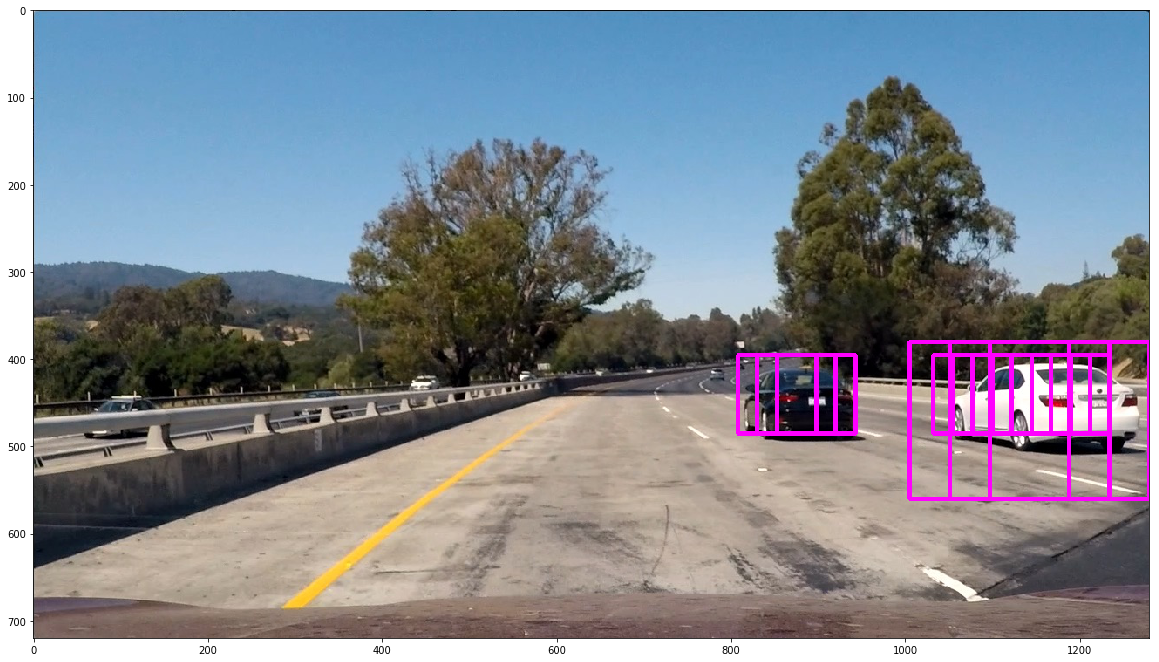

In [27]:
def annotate_selected_windows_on_test_image_verbose():
    path = 'test_images/test1.jpg'
    img_bgr = cv2.imread(path)
    img_rgb = np.array(img_bgr[:,:,::-1])
    
    for x0,x1,y0,y1 in select_windows(img_rgb, verbose=True):
        cv2.rectangle(img_rgb, (x0,y0), (x1,y1), (255,0,255), 3)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(img_rgb)

annotate_selected_windows_on_test_image_verbose()

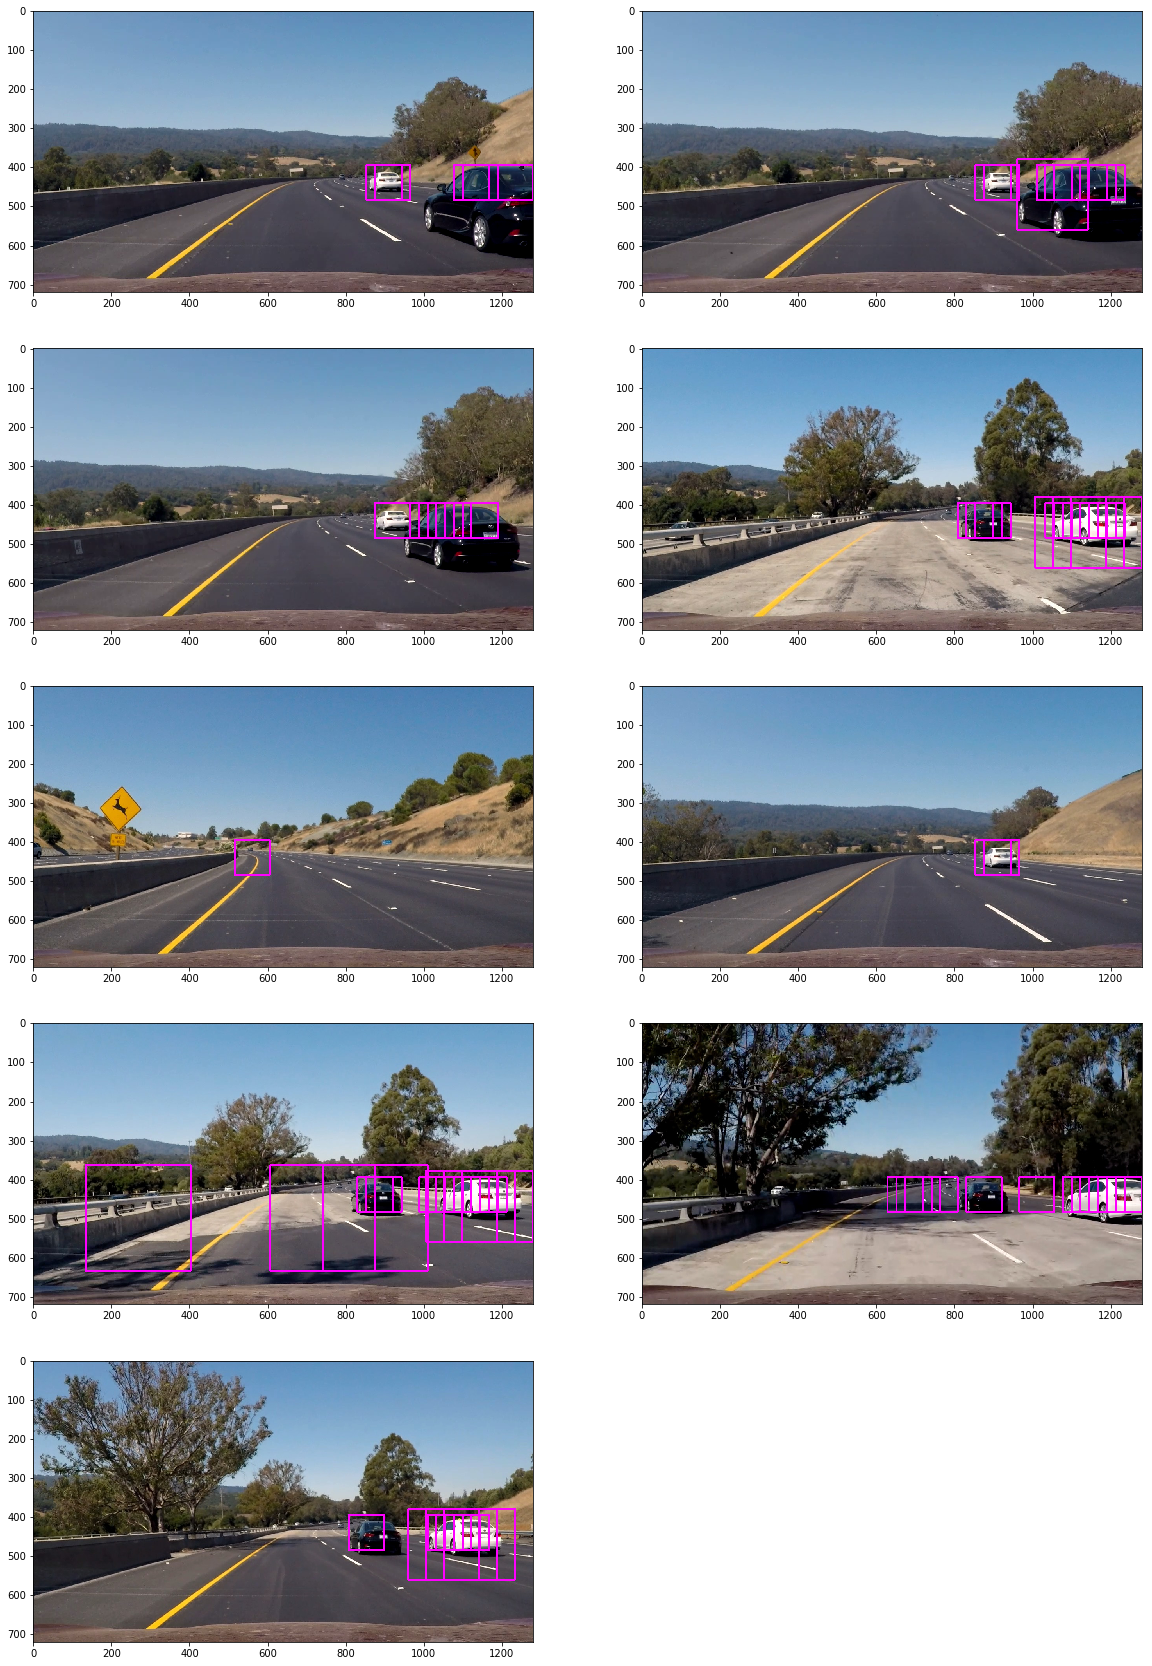

In [28]:
def annotate_selected_windows_on_test_images_quiet():
    img_paths = glob.glob('test_images/*')
    fig, axes = plt.subplots(ncols=2, nrows=math.ceil(len(img_paths) / 2), figsize=(20, 30))
    axes = axes.flatten()
    for ax in axes[len(img_paths):]:
        ax.remove()
    
    for img_path, ax in zip(img_paths, axes):
        img_bgr = cv2.imread(img_path)
        img_rgb = np.array(img_bgr[:,:,::-1])
        
        for x0,x1,y0,y1 in select_windows(img_rgb):
            cv2.rectangle(img_rgb, (x0,y0), (x1,y1), (255,0,255), 3)
        
        ax.imshow(img_rgb)

annotate_selected_windows_on_test_images_quiet()

### Pass found windows to heatmap

In [6]:
def reduce_windows_to_box_per_car(img_hw, selected_windows_for_curr_frame, heatmap_history_pointer):
    def get_heatmap_for_one_frame(boxes):
        heat = np.zeros(img_hw)
        for x0,x1,y0,y1 in boxes:
            heat[y0:y1, x0:x1] += 1
        return heat
    
    def apply_threshold(heatmaps):
        combined_heatmap = np.sum(heatmaps, axis=0)
        
        # Recognize an area such that, in at least one frame, the area is an overlap of 2 or more windows.
        threshold = len(heatmaps) + 1
        combined_heatmap[combined_heatmap < threshold] = 0
        
        return combined_heatmap
    
    def get_label_boxes_from_heatmap(heatmap):
        img_labels, num_labels = scipy.ndimage.measurements.label(heatmap)
        boxes = []
        for car_number in range(1, num_labels + 1):
            y_coords, x_coords = (img_labels == car_number).nonzero()
            y0 = np.min(y_coords)
            y1 = np.max(y_coords)
            x0 = np.min(x_coords)
            x1 = np.max(x_coords)
            boxes.append((x0,x1,y0,y1))
        return boxes
    
    curr_heatmap = get_heatmap_for_one_frame(selected_windows_for_curr_frame)
    
    heatmap_history = heatmap_history_pointer[0]
    
    recent_heatmaps = [b for b in heatmap_history if b is not None] + [curr_heatmap]

    combined_heatmap = apply_threshold(recent_heatmaps)
    
    label_boxes = get_label_boxes_from_heatmap(combined_heatmap)

    heatmap_history = heatmap_history[1:] + [curr_heatmap]
    heatmap_history_pointer[0] = heatmap_history
    
    return label_boxes

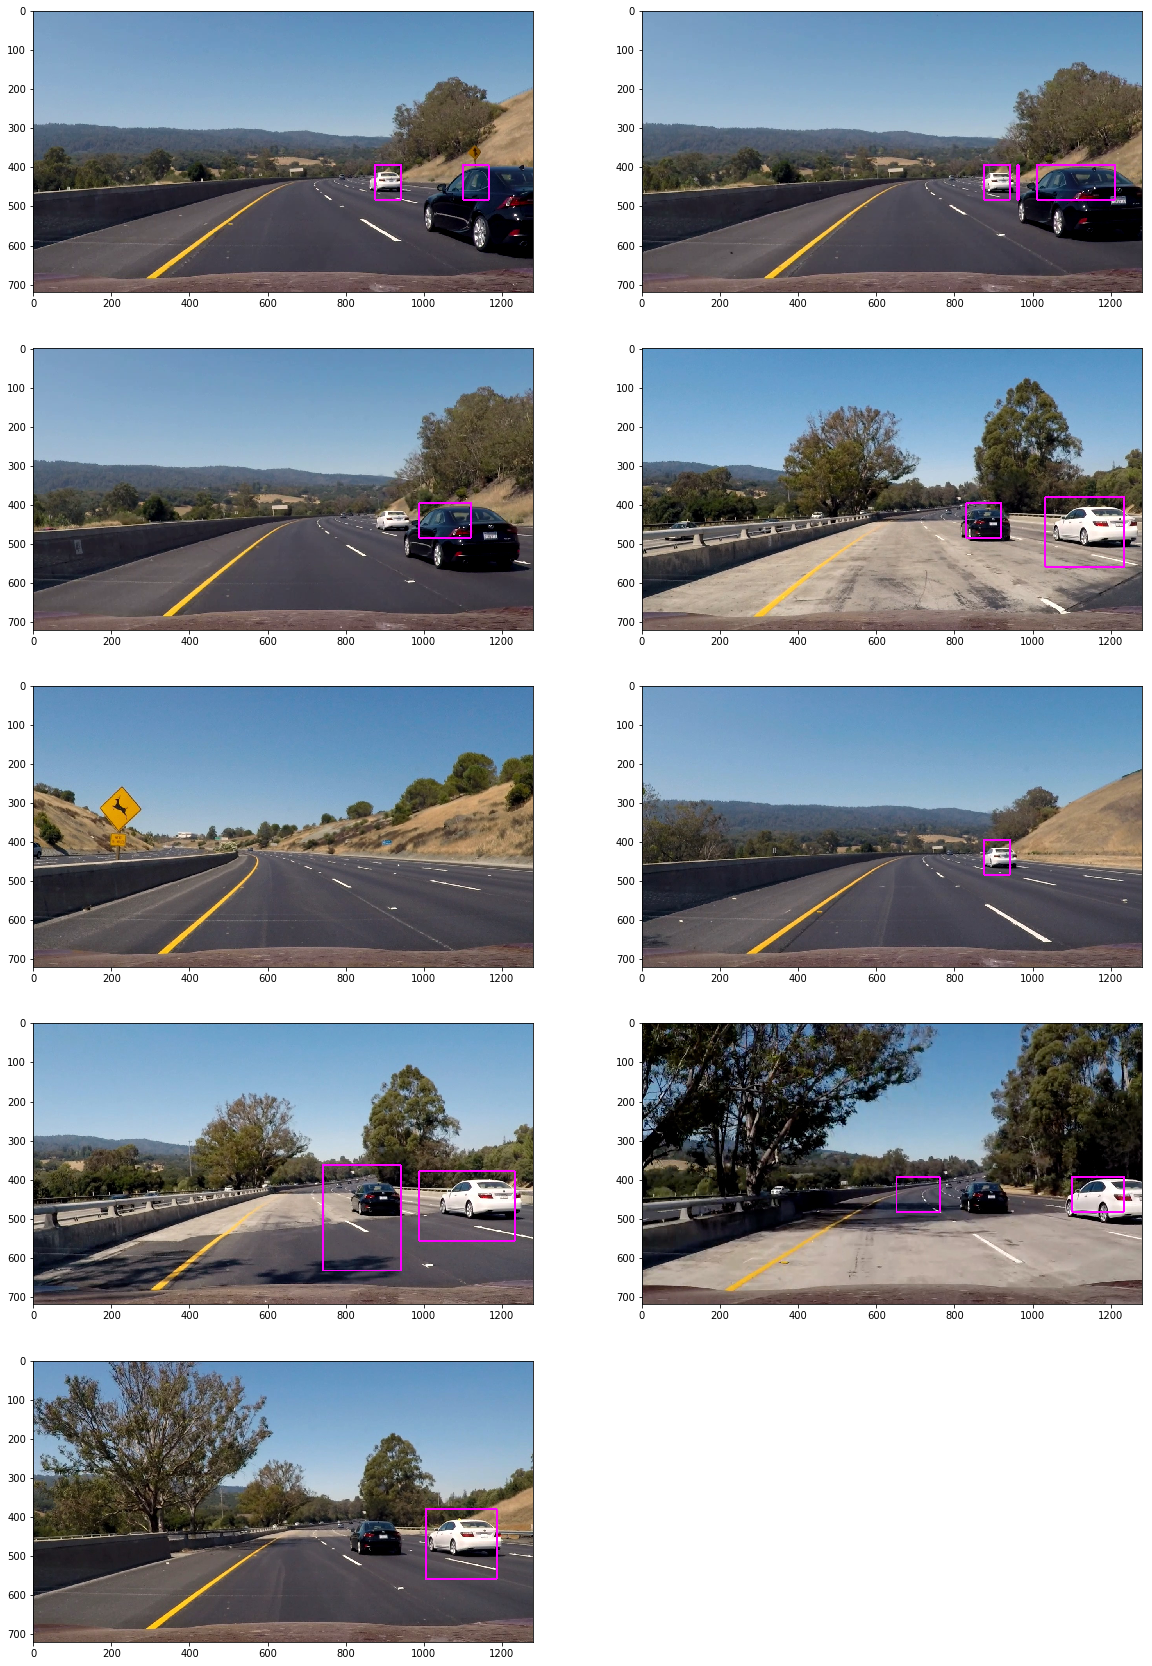

In [42]:
def annotate_heatmap_on_test_images():
    img_paths = glob.glob('test_images/*')
    fig, axes = plt.subplots(ncols=2, nrows=math.ceil(len(img_paths) / 2), figsize=(20, 30))
    axes = axes.flatten()
    for ax in axes[len(img_paths):]:
        ax.remove()
    
    for img_path, ax in zip(img_paths, axes):
        img_bgr = cv2.imread(img_path)
        img_rgb = np.array(img_bgr[:,:,::-1])
        
        selected_windows_for_curr_frame = select_windows(img_rgb)
    
        mock_heatmap_history = []
        mock_heatmap_history_pointer = [mock_heatmap_history]
        
        box_per_car = reduce_windows_to_box_per_car(img_rgb.shape[:2], selected_windows_for_curr_frame, mock_heatmap_history_pointer)

        for x0,x1,y0,y1 in box_per_car:
            cv2.rectangle(img_rgb, (x0,y0), (x1,y1), (255,0,255), 3)
        
        ax.imshow(img_rgb)

annotate_heatmap_on_test_images()

# Video

In [7]:
def annotate_video(in_path, out_path):
    heatmap_history = [None] * 3
    heatmap_history_pointer = [heatmap_history]
    
    frame_times = []
    
    def pipeline(img_rgb):
        t0 = time.time()
        
        selected_windows_for_curr_frame = select_windows(img_rgb)
    
        box_per_car = reduce_windows_to_box_per_car(img_rgb.shape[:2], selected_windows_for_curr_frame, heatmap_history_pointer)

        for x0,x1,y0,y1 in box_per_car:
            cv2.rectangle(img_rgb, (x0,y0), (x1,y1), (255,0,255), 3)
        
        t1 = time.time()
        frame_times.append(t1 - t0)
        
        return img_rgb
    
    in_clip = VideoFileClip(in_path)
    out_clip = in_clip.fl_image(pipeline)
    %time out_clip.write_videofile(out_path, audio=False)
    
    print('time spent per frame: avg = ', np.mean(frame_times), 'std = ', np.std(frame_times))

In [12]:
annotate_video('test_video.mp4', 'output_images/annotated_test_video.mp4')

[MoviePy] >>>> Building video output_images/annotated_test_video.mp4
[MoviePy] Writing video output_images/annotated_test_video.mp4


 97%|█████████▋| 38/39 [00:06<00:00,  5.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/annotated_test_video.mp4 

CPU times: user 11.9 s, sys: 4.19 s, total: 16.1 s
Wall time: 6.93 s
time spent per frame: avg =  0.160185905603 std =  0.00990504560723


In [10]:
annotate_video('project_video.mp4', 'output_images/annotated_project_video.mp4')

[MoviePy] >>>> Building video output_images/annotated_project_video.mp4
[MoviePy] Writing video output_images/annotated_project_video.mp4


100%|█████████▉| 1260/1261 [03:37<00:00,  5.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/annotated_project_video.mp4 

CPU times: user 5min 48s, sys: 2min 43s, total: 8min 32s
Wall time: 3min 37s
time spent per frame: avg =  0.166768814816 std =  0.0086595418837


### Extra: annotate vehicle detection + lane detection

In [28]:
# I am going to cheat by annotating vehicle detection on top of
# already annotated lane lines from the previous project.
# I am not running the lane detection pipeline.
def annotate_on_another_video(vehicle_detection_in_path, bg_in_path, out_path):
    heatmap_history = [None] * 3
    heatmap_history_pointer = [heatmap_history]
    
    car_boxes_per_frame = []
    
    def save_car_boxes(img_rgb):
        selected_windows_for_curr_frame = select_windows(img_rgb)
    
        car_boxes = reduce_windows_to_box_per_car(img_rgb.shape[:2], selected_windows_for_curr_frame, heatmap_history_pointer)

        car_boxes_per_frame.append(car_boxes)
        
        return img_rgb

    def annotate_car_boxes(img_rgb):
        nonlocal car_boxes_per_frame
        
        if len(car_boxes_per_frame) > 0:
            car_boxes = car_boxes_per_frame[0]
            car_boxes_per_frame = car_boxes_per_frame[1:]
            
            for x0,x1,y0,y1 in car_boxes:
                cv2.rectangle(img_rgb, (x0,y0), (x1,y1), (0, 255,255), 3)
        
        return img_rgb
    
    vehicle_detection_in_clip = VideoFileClip(vehicle_detection_in_path)
    discarded_clip = vehicle_detection_in_clip.fl_image(save_car_boxes)
    discarded_clip.write_videofile(out_path, audio=False)
    
    bg_in_clip = VideoFileClip(bg_in_path)
    out_clip = bg_in_clip.fl_image(annotate_car_boxes)
    out_clip.write_videofile(out_path, audio=False)

# For the video with lane lines already annotated, see
# https://ysono.github.io/CarND-T1P4-Advanced-Lane-Lines/output_videos/project_video_annotated.mp4
annotate_on_another_video(
    'project_video.mp4',
    '../CarND-T1P4-Advanced-Lane-Lines/output_videos/project_video_annotated.mp4',
    'output_images/annotated_project_video_with_lane_lines.mp4')

[MoviePy] >>>> Building video output_images/annotated_project_video_with_lane_lines.mp4
[MoviePy] Writing video output_images/annotated_project_video_with_lane_lines.mp4


100%|█████████▉| 1260/1261 [03:40<00:00,  5.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/annotated_project_video_with_lane_lines.mp4 

[MoviePy] >>>> Building video output_images/annotated_project_video_with_lane_lines.mp4
[MoviePy] Writing video output_images/annotated_project_video_with_lane_lines.mp4


100%|█████████▉| 1260/1261 [00:20<00:00, 62.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/annotated_project_video_with_lane_lines.mp4 

